In [305]:
!pip install kaggle

In [306]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [307]:
!cp kaggle.json ~/.kaggle

In [308]:
!chmod 600 ~/.kaggle/kaggle.json

In [309]:
!kaggle datasets download datafiniti/consumer-reviews-of-amazon-products

consumer-reviews-of-amazon-products.zip: Skipping, found more recently modified local copy (use --force to force download)


In [310]:
!unzip consumer-reviews-of-amazon-products.zip

Archive:  consumer-reviews-of-amazon-products.zip
replace 1429_1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [311]:
!pip install nltk
!pip install nlpaug

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
import nlpaug.augmenter.word as naw
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [313]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [314]:
dataset = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
dataset1 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
dataset2 = pd.read_csv("1429_1.csv")

<ipython-input-314-4878cf746fb0>:3: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset2 = pd.read_csv("1429_1.csv")


In [315]:
con_df = pd.concat([dataset , dataset1 , dataset2] , ignore_index = True)

In [316]:
con_df.to_csv('concatenated_dataset.csv' , index=False)

In [317]:
df = pd.read_csv("concatenated_dataset.csv")

<ipython-input-317-34cd57be58af>:1: DtypeWarning: Columns (1,2,3,7,8,11,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("concatenated_dataset.csv")


In [318]:
data = con_df[["name" , "asins" , "reviews.rating" , "reviews.text" , "reviews.username"]]
data.columns = ['p_name', 'p_id', 'rating', 'review' , 'user']

In [319]:
data.isnull().sum()

p_name    6760
p_id         2
rating      33
review       1
user        13
dtype: int64

In [320]:
def fill_product_name():
    data.loc[:, 'p_name'] = data.groupby('p_id')['p_name'].transform(lambda x: x.fillna(method='ffill'))
fill_product_name()
data.isnull().sum()

p_name    5126
p_id         2
rating      33
review       1
user        13
dtype: int64

In [321]:
data.dropna(subset=['p_name' , 'rating' , 'user' , 'review'], inplace=True)

<ipython-input-321-f8c8dc9354f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['p_name' , 'rating' , 'user' , 'review'], inplace=True)


In [322]:
data.isnull().sum()

p_name    0
p_id      0
rating    0
review    0
user      0
dtype: int64

In [323]:
data.shape

(62821, 5)

In [324]:
sentiment_score = {
    1:0,
    2:0,
    3:0,
    4:1,
    5:1,
}
sentiment = {
    0:'Negative',
    1:'Positive'
}
data['sentiment_score'] = data['rating'].map(sentiment_score)
data['sentiment'] = data['sentiment_score'].map(sentiment)
data.head()

<ipython-input-324-c9ea0a430b3a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment_score'] = data['rating'].map(sentiment_score)
<ipython-input-324-c9ea0a430b3a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['sentiment_score'].map(sentiment)


,p_name,p_id,rating,review,user,sentiment_score,sentiment
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,3.000,I thought it would be as big as small paper bu...,llyyue,0,Negative
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,5.000,This kindle is light and easy to use especiall...,Charmi,1,Positive
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,4.000,Didnt know how much i'd use a kindle so went f...,johnnyjojojo,1,Positive
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,5.000,I am 100 happy with my purchase. I caught it o...,Kdperry,1,Positive
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,5.000,Solid entry level Kindle. Great for kids. Gift...,Johnnyblack,1,Positive


In [325]:
num_users = data["user"].nunique()
num_product = data["p_id"].nunique()
print("number of unique users:",num_users)
print("number of unique products:",num_product)

number of unique users: 33812
number of unique products: 83


In [326]:
data.describe()

,rating,sentiment_score
count,62821.000,62821.000
mean,4.545,0.918
std,0.836,0.275
min,1.000,0.000
25%,4.000,1.000
50%,5.000,1.000
75%,5.000,1.000
max,5.000,1.000


In [327]:
rating = pd.DataFrame(data['rating'].value_counts()).reset_index()
rating.columns = ['rating ' , 'counts']
rating

,rating,counts
0,5.000,43206
1,4.000,14440
2,3.000,2761
3,1.000,1381
4,2.000,1033


array([[<Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'sentiment_score'}>]], dtype=object)

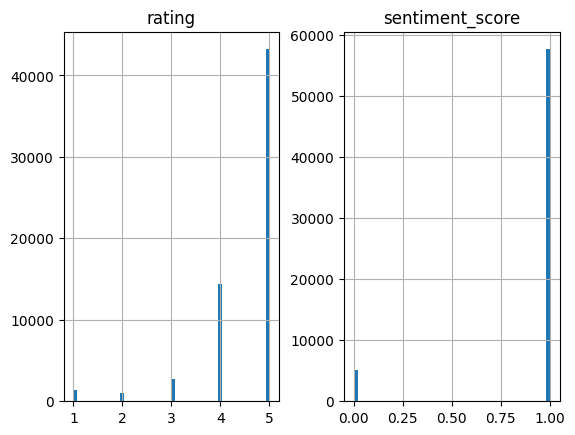

In [328]:
data.hist(bins=50)

In [329]:
popular_data = data.groupby("p_id").filter(lambda x:x["rating"].count()>=500)
popular_product = pd.DataFrame(popular_data.groupby('p_id')['rating'].count())
popular_product = popular_product.sort_values('rating', ascending=False)

Text(0.5, 1.0, 'popular product bar chart')

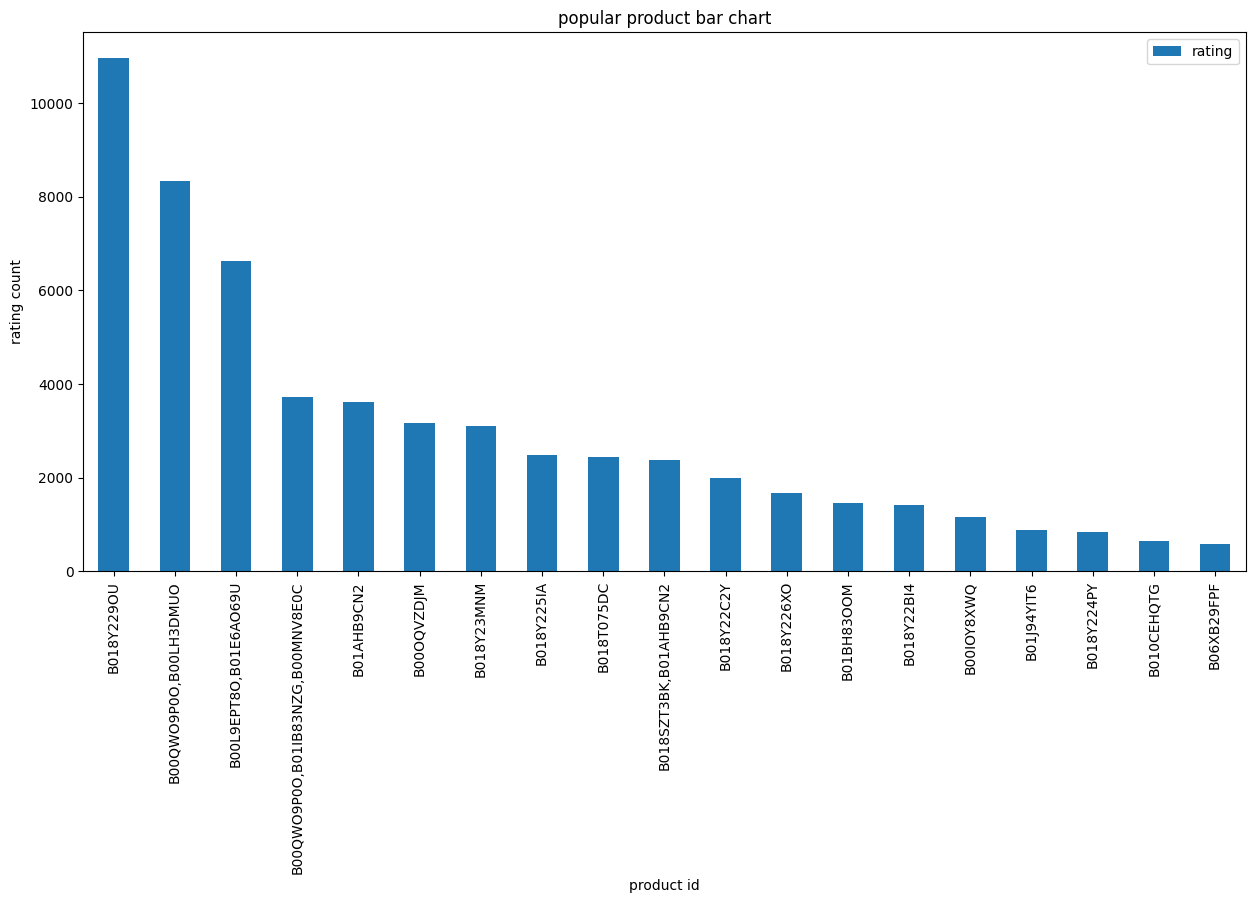

In [330]:
ax = popular_product.head(30).plot(kind = "bar" , figsize=(15,7))
ax.set_xlabel("product id")
ax.set_ylabel("rating count")
ax.set_title('popular product bar chart')

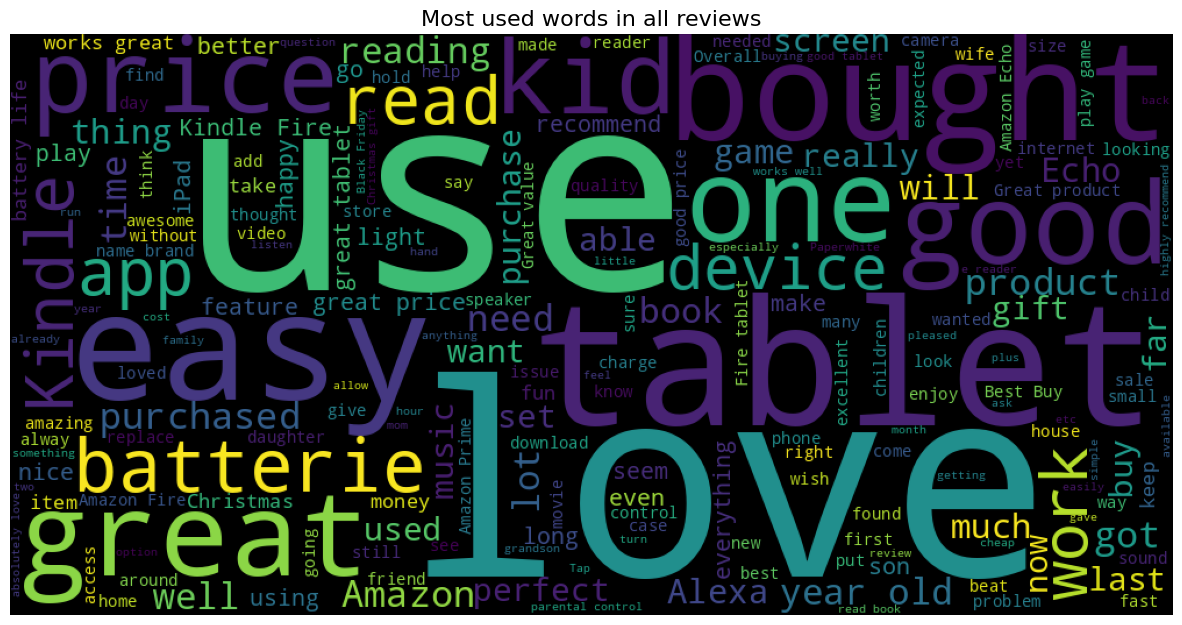

In [331]:
all_words = pd.Series(' '.join(data['review']).split())
word_cloud = WordCloud(width=1000 , height = 500).generate(' '.join(all_words))
fig = plt.figure(figsize=(15,8))
plt.imshow(word_cloud)
plt.title("Most used words in all reviews",size=16)
plt.axis("off")
plt.show()

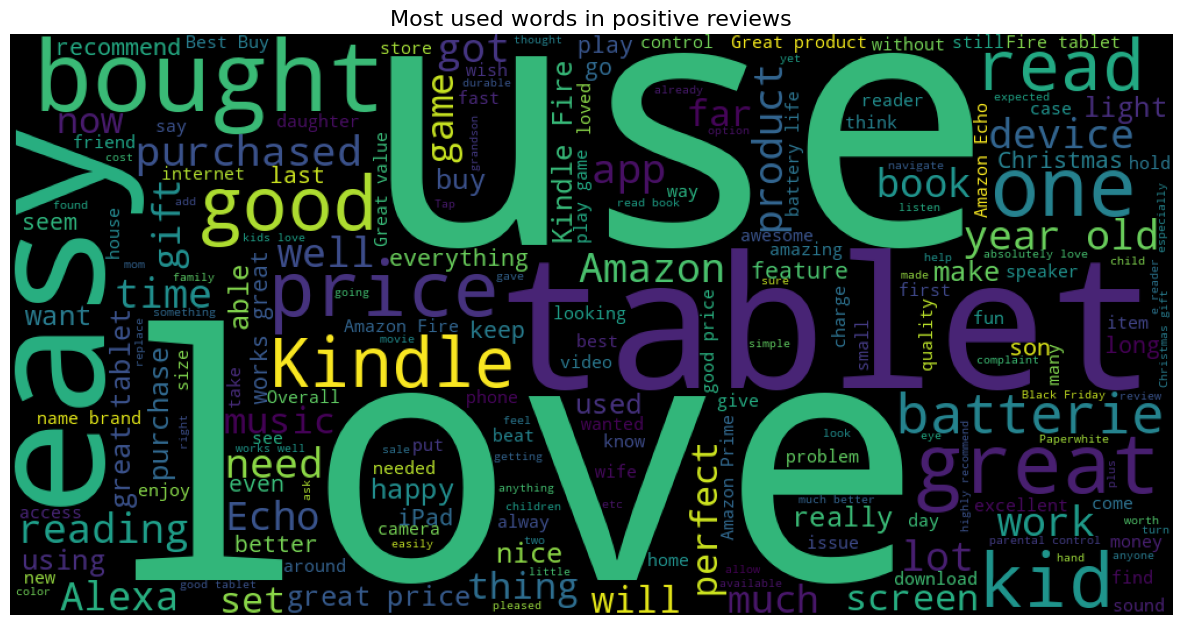

In [332]:
pos_words = pd.Series(' '.join(data[data['sentiment']=='Positive']['review']).split())
word_cloud = WordCloud(width=1000 , height = 500).generate(' '.join(pos_words))
fig = plt.figure(figsize=(15,8))
plt.imshow(word_cloud)
plt.title("Most used words in positive reviews",size=16)
plt.axis("off")
plt.show()

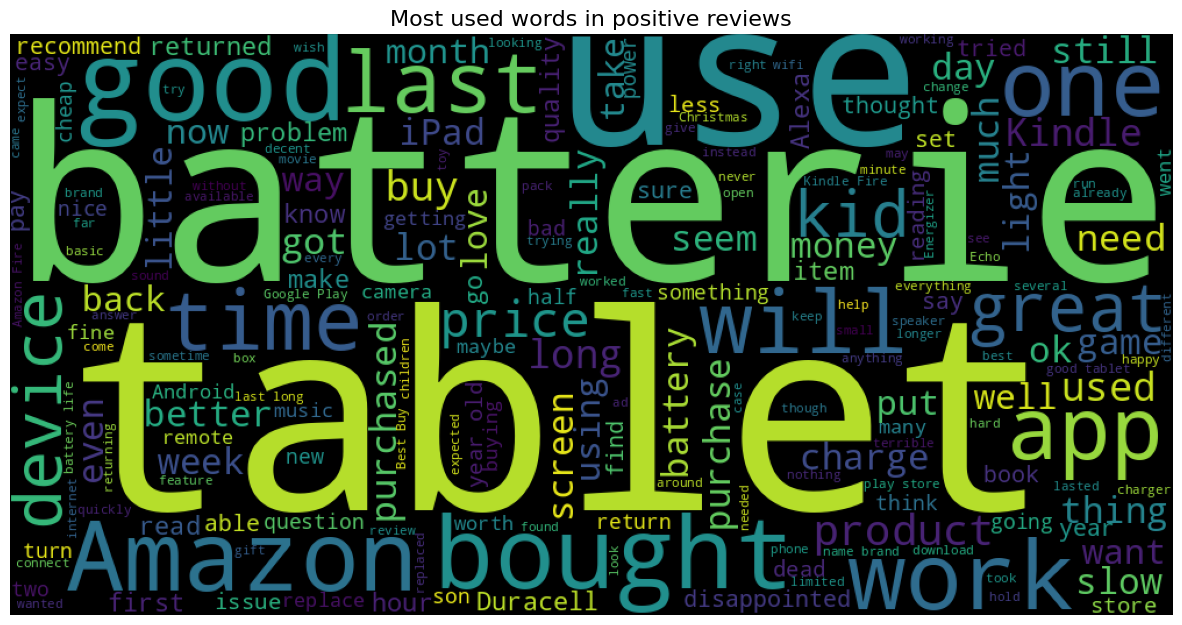

In [333]:
neg_words = pd.Series(' '.join(data[data['sentiment']=='Negative']['review']).split())
word_cloud = WordCloud(width=1000 , height = 500).generate(' '.join(neg_words))
fig = plt.figure(figsize=(15,8))
plt.imshow(word_cloud)
plt.title("Most used words in positive reviews",size=16)
plt.axis("off")
plt.show()

In [334]:
def remove_abb(data):
    data = re.sub(r"he's", "he is", data)
    data = re.sub(r"there's", "there is", data)
    data = re.sub(r"We're", "We are", data)
    data = re.sub(r"That's", "That is", data)
    data = re.sub(r"won't", "will not", data)
    data = re.sub(r"they're", "they are", data)
    data = re.sub(r"Can't", "Cannot", data)
    data = re.sub(r"wasn't", "was not", data)
    data = re.sub(r"don\x89Ûªt", "do not", data)
    data= re.sub(r"aren't", "are not", data)
    data = re.sub(r"isn't", "is not", data)
    data = re.sub(r"What's", "What is", data)
    data = re.sub(r"haven't", "have not", data)
    data = re.sub(r"hasn't", "has not", data)
    data = re.sub(r"There's", "There is", data)
    data = re.sub(r"He's", "He is", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"You're", "You are", data)
    data = re.sub(r"I'M", "I am", data)
    data = re.sub(r"shouldn't", "should not", data)
    data = re.sub(r"wouldn't", "would not", data)
    data = re.sub(r"i'm", "I am", data)
    data = re.sub(r"I\x89Ûªm", "I am", data)
    data = re.sub(r"I'm", "I am", data)
    data = re.sub(r"Isn't", "is not", data)
    data = re.sub(r"Here's", "Here is", data)
    data = re.sub(r"you've", "you have", data)
    data = re.sub(r"you\x89Ûªve", "you have", data)
    data = re.sub(r"we're", "we are", data)
    data = re.sub(r"what's", "what is", data)
    data = re.sub(r"couldn't", "could not", data)
    data = re.sub(r"we've", "we have", data)
    data = re.sub(r"it\x89Ûªs", "it is", data)
    data = re.sub(r"doesn\x89Ûªt", "does not", data)
    data = re.sub(r"It\x89Ûªs", "It is", data)
    data = re.sub(r"Here\x89Ûªs", "Here is", data)
    data = re.sub(r"who's", "who is", data)
    data = re.sub(r"I\x89Ûªve", "I have", data)
    data = re.sub(r"y'all", "you all", data)
    data = re.sub(r"can\x89Ûªt", "cannot", data)
    data = re.sub(r"would've", "would have", data)
    data = re.sub(r"it'll", "it will", data)
    data = re.sub(r"we'll", "we will", data)
    data = re.sub(r"wouldn\x89Ûªt", "would not", data)
    data = re.sub(r"We've", "We have", data)
    data = re.sub(r"he'll", "he will", data)
    data = re.sub(r"Y'all", "You all", data)
    data = re.sub(r"Weren't", "Were not", data)
    data = re.sub(r"Didn't", "Did not", data)
    data = re.sub(r"they'll", "they will", data)
    data = re.sub(r"they'd", "they would", data)
    data = re.sub(r"DON'T", "DO NOT", data)
    data = re.sub(r"That\x89Ûªs", "That is", data)
    data = re.sub(r"they've", "they have", data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"should've", "should have", data)
    data = re.sub(r"You\x89Ûªre", "You are", data)
    data = re.sub(r"where's", "where is", data)
    data = re.sub(r"Don\x89Ûªt", "Do not", data)
    data = re.sub(r"we'd", "we would", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"weren't", "were not", data)
    data = re.sub(r"They're", "They are", data)
    data = re.sub(r"Can\x89Ûªt", "Cannot", data)
    data = re.sub(r"you\x89Ûªll", "you will", data)
    data = re.sub(r"I\x89Ûªd", "I would", data)
    data = re.sub(r"let's", "let us", data)
    data = re.sub(r"it's", "it is", data)
    data = re.sub(r"can't", "cannot", data)
    data = re.sub(r"don't", "do not", data)
    data = re.sub(r"you're", "you are", data)
    data = re.sub(r"i've", "I have", data)
    data = re.sub(r"that's", "that is", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"doesn't", "does not",data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"didn't", "did not", data)
    data = re.sub(r"ain't", "am not", data)
    data = re.sub(r"you'll", "you will", data)
    data = re.sub(r"I've", "I have", data)
    data = re.sub(r"Don't", "do not", data)
    data = re.sub(r"I'll", "I will", data)
    data = re.sub(r"I'd", "I would", data)
    data = re.sub(r"Let's", "Let us", data)
    data = re.sub(r"you'd", "You would", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"Ain't", "am not", data)
    data = re.sub(r"Haven't", "Have not", data)
    data = re.sub(r"Could've", "Could have", data)
    data = re.sub(r"youve", "you have", data)
    data = re.sub(r"donå«t", "do not", data)
    return data
data['review']=data['review'].apply(lambda z: remove_abb(z))

<ipython-input-334-e82bfe860c50>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review']=data['review'].apply(lambda z: remove_abb(z))


In [335]:

def has_url(text):
    return bool(re.search(r'http\S+', text))

def has_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002500-\U00002BEF"
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return bool(re.search(emoji_pattern, text))

def has_html_tags(text):
    return bool(re.search(r'<.*?>', text))
def has_punctuation(text):
    for char in text:
        if char in string.punctuation:
            return True
    return False


data['has'] = data['review'].apply(has_punctuation)
data['has_url'] = data['review'].apply(has_url)
data['has_emoji'] = data['review'].apply(has_emoji)
data['has_html_tags'] = data['review'].apply(has_html_tags)

num_punctuations = data[data['has']]
num_urls = data[data['has_url']]
num_emojis = data[data['has_emoji']]
num_html_tags = data[data['has_html_tags']]

print("punctuations :",len(num_punctuations))
print("urls :",len(num_urls))
print("emojis :", len(num_emojis))
print("html :", len(num_html_tags))


<ipython-input-335-43199f93e396>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['has'] = data['review'].apply(has_punctuation)
<ipython-input-335-43199f93e396>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['has_url'] = data['review'].apply(has_url)


punctuations : 56094
urls : 9
emojis : 15
html : 0


<ipython-input-335-43199f93e396>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['has_emoji'] = data['review'].apply(has_emoji)
<ipython-input-335-43199f93e396>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['has_html_tags'] = data['review'].apply(has_html_tags)


In [336]:
def remove_punctuation(data):
    translator = str.maketrans('', '', string.punctuation)
    return data.translate(translator)
def remove_urls(text):
    return re.sub(r'http\S+', '', text)
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



data['review'] = data['review'].apply(lambda z: remove_punctuation(z))
data['review'] = data['review'].apply(lambda z: remove_urls(z))
data['review'] = data['review'].apply(lambda z: remove_emojis(z))

<ipython-input-336-654c63d4c3e6>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review'] = data['review'].apply(lambda z: remove_punctuation(z))
<ipython-input-336-654c63d4c3e6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review'] = data['review'].apply(lambda z: remove_urls(z))
<ipython-input-336-654c63d4c3e6>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [337]:
data['has'] = data['review'].apply(has_punctuation)
data['has_url'] = data['review'].apply(has_url)
data['has_emoji'] = data['review'].apply(has_emoji)

num_punctuations = data[data['has']]
num_urls = data[data['has_url']]
num_emojis = data[data['has_emoji']]

print("punctuations :",len(num_punctuations))
print("urls :",len(num_urls))
print("emojis :",len(num_emojis))

<ipython-input-337-364c25f9d9b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['has'] = data['review'].apply(has_punctuation)
<ipython-input-337-364c25f9d9b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['has_url'] = data['review'].apply(has_url)


punctuations : 0
urls : 0
emojis : 0


<ipython-input-337-364c25f9d9b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['has_emoji'] = data['review'].apply(has_emoji)


In [338]:
data

,p_name,p_id,rating,review,user,sentiment_score,sentiment,has,has_url,has_emoji,has_html_tags
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,3.000,I thought it would be as big as small paper bu...,llyyue,0,Negative,False,False,False,False
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,5.000,This kindle is light and easy to use especiall...,Charmi,1,Positive,False,False,False,False
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,4.000,Didnt know how much I would use a kindle so we...,johnnyjojojo,1,Positive,False,False,False,False
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,5.000,I am 100 happy with my purchase I caught it on...,Kdperry,1,Positive,False,False,False,False
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,5.000,Solid entry level Kindle Great for kids Gifted...,Johnnyblack,1,Positive,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
62899,Amazon Tap Smart Assistant Alexaenabled (black...,B01BH83OOM,5.000,I bought the Amazon Tap when it was on sale I ...,Vol865,1,Positive,False,False,False,False
62900,Amazon Tap Smart Assistant Alexaenabled (black...,B01BH83OOM,5.000,I like it I use it everyday and so far no cons...,romaeeeeee,1,Positive,False,False,False,False
62901,Amazon Tap Smart Assistant Alexaenabled (black...,B01BH83OOM,5.000,I literally use this thing every single day Lo...,tbistone,1,Positive,False,False,False,False
62902,Amazon Tap Smart Assistant Alexaenabled (black...,B01BH83OOM,5.000,I absolutely love my amazon echo It is very co...,Bamafever78,1,Positive,False,False,False,False


In [339]:
def remove_stopwords(text):
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)
    return filtered_sentence
data['review'] = data['review'].apply(remove_stopwords)

<ipython-input-339-fa882b8f2700>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review'] = data['review'].apply(remove_stopwords)


In [340]:
data

,p_name,p_id,rating,review,user,sentiment_score,sentiment,has,has_url,has_emoji,has_html_tags
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,3.000,thought would big small paper turn like palm t...,llyyue,0,Negative,False,False,False,False
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,5.000,kindle light easy use especially beach,Charmi,1,Positive,False,False,False,False
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,4.000,Didnt know much would use kindle went lower en...,johnnyjojojo,1,Positive,False,False,False,False
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,5.000,100 happy purchase caught sale really good pri...,Kdperry,1,Positive,False,False,False,False
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,5.000,Solid entry level Kindle Great kids Gifted kid...,Johnnyblack,1,Positive,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
62899,Amazon Tap Smart Assistant Alexaenabled (black...,B01BH83OOM,5.000,bought Amazon Tap sale already Amazon Echo Dot...,Vol865,1,Positive,False,False,False,False
62900,Amazon Tap Smart Assistant Alexaenabled (black...,B01BH83OOM,5.000,like use everyday far cons Im please,romaeeeeee,1,Positive,False,False,False,False
62901,Amazon Tap Smart Assistant Alexaenabled (black...,B01BH83OOM,5.000,literally use thing every single day Love,tbistone,1,Positive,False,False,False,False
62902,Amazon Tap Smart Assistant Alexaenabled (black...,B01BH83OOM,5.000,absolutely love amazon echo convenient handy,Bamafever78,1,Positive,False,False,False,False


In [341]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [342]:
def lemma_traincorpus(data):
    lemmatizer=WordNetLemmatizer()
    out_data=""
    for words in data:
        out_data+= lemmatizer.lemmatize(words)
    return out_data

In [343]:
new_data = data[['review' , 'sentiment_score']]

In [344]:
remove = new_data[new_data['sentiment_score'] == 1]
num_to_remove = int(len(remove) * 0.6)
samples_to_remove = remove.sample(n=num_to_remove)
new_data = new_data.drop(samples_to_remove.index)

In [345]:
def augment_text(text):
    aug = naw.SynonymAug(aug_src='wordnet', aug_max=2)
    augmented_samples = [aug.augment(text) for _ in range(3)]
    return augmented_samples

In [346]:
from collections import Counter

class_counts = Counter(y_train_augmented)

sentiment = pd.DataFrame(class_counts.items(), columns=['index', 'counts'])
sentiment

,index,counts
0,0,20700
1,1,23059


In [347]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_augmented)
X = tokenizer.texts_to_sequences(X_train_augmented)
X = pad_sequences(X)
y = y_train_augmented


In [348]:
X_train, X_test, y_train, y_test = train_test_split(X, y_train_augmented, test_size=0.2)

In [349]:
X_train = X_train.tolist()
X_test = X_test.tolist()
print(y_train)

[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 

In [350]:
embedding_dim = 100
max_length = X.shape[1]
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=60))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [351]:
history = model.fit(X_train, y_train, batch_size=128, epochs=4, validation_data=(X_test, y_test))

Epoch 1/4
274/274 [==============================] - 497s 2s/step - loss: 0.2283 - accuracy: 0.9185 - val_loss: 0.0484 - val_accuracy: 0.9902
Epoch 2/4
274/274 [==============================] - 467s 2s/step - loss: 0.0306 - accuracy: 0.9919 - val_loss: 0.0182 - val_accuracy: 0.9968
Epoch 3/4
274/274 [==============================] - 480s 2s/step - loss: 0.0138 - accuracy: 0.9971 - val_loss: 0.0108 - val_accuracy: 0.9983
Epoch 4/4
274/274 [==============================] - 469s 2s/step - loss: 0.0083 - accuracy: 0.9983 - val_loss: 0.0085 - val_accuracy: 0.9985


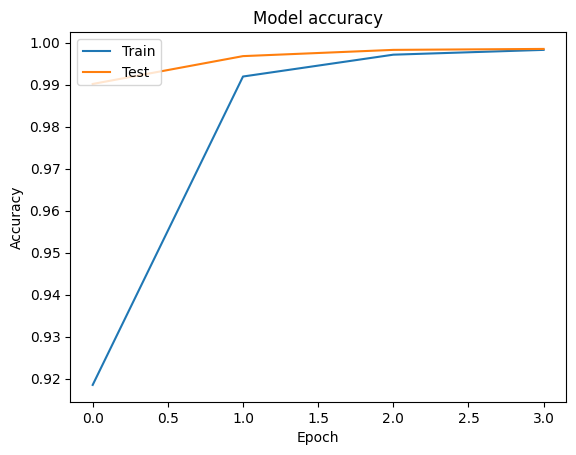

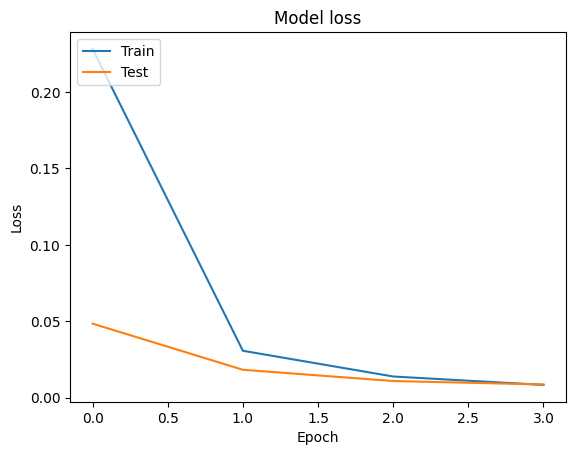

In [352]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [353]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(y_pred)


274/274 [==============================] - 33s 119ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4110
           1       1.00      1.00      1.00      4642

    accuracy                           1.00      8752
   macro avg       1.00      1.00      1.00      8752
weighted avg       1.00      1.00      1.00      8752

[[4104    6]
 [   7 4635]]
[[False]
 [ True]
 [False]
 ...
 [False]
 [ True]
 [ True]]


In [354]:
cf_data = data[['user' , 'p_id' , 'rating' , 'p_name']]

In [355]:
product_rating_count = (cf_data.
     groupby(by = ['p_id'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['p_id', 'totalRatingCount']]
    )
product_rating_count.head()

,p_id,totalRatingCount
0,"B0002LCUZK,B010CEC6MI,B01B25NN64",9
1,B001NIZB5M,5
2,B005OOKNP4,6
3,B005PB2T0S,5
4,B005PB2T2Q,6


In [356]:
rating_with_totalRatingCount = cf_data.merge(product_rating_count, left_on = 'p_id', right_on = 'p_id', how = 'left')
rating_with_totalRatingCount.head()

,user,p_id,rating,p_name,totalRatingCount
0,llyyue,B00ZV9PXP2,3.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325
1,Charmi,B00ZV9PXP2,5.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325
2,johnnyjojojo,B00ZV9PXP2,4.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325
3,Kdperry,B00ZV9PXP2,5.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325
4,Johnnyblack,B00ZV9PXP2,5.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325


In [357]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(product_rating_count.describe())

       totalRatingCount
count            83.000
mean            756.880
std            1802.660
min               1.000
25%               5.000
50%              62.000
75%             386.500
max           10965.000


In [358]:
popularity_threshold = 100
rating_popular_product= rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_product.head()

,user,p_id,rating,p_name,totalRatingCount
0,llyyue,B00ZV9PXP2,3.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325
1,Charmi,B00ZV9PXP2,5.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325
2,johnnyjojojo,B00ZV9PXP2,4.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325
3,Kdperry,B00ZV9PXP2,5.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325
4,Johnnyblack,B00ZV9PXP2,5.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325


In [359]:
rating_popular_product.shape

(62282, 5)

In [360]:
label_encoder = LabelEncoder()
rating_popular_product['userid'] = label_encoder.fit_transform(rating_popular_product['user'])

<ipython-input-360-141242c8cd2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_popular_product['userid'] = label_encoder.fit_transform(rating_popular_product['user'])


In [361]:

label_encoder = LabelEncoder()
rating_popular_product['productid'] = label_encoder.fit_transform(rating_popular_product['p_id'])

<ipython-input-361-03179b86722a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_popular_product['productid'] = label_encoder.fit_transform(rating_popular_product['p_id'])


In [362]:
rating_popular_product

,user,p_id,rating,p_name,totalRatingCount,userid,productid
0,llyyue,B00ZV9PXP2,3.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325,30407,10
1,Charmi,B00ZV9PXP2,5.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325,11668,10
2,johnnyjojojo,B00ZV9PXP2,4.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325,29744,10
3,Kdperry,B00ZV9PXP2,5.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325,17382,10
4,Johnnyblack,B00ZV9PXP2,5.000,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",325,16791,10
...,...,...,...,...,...,...,...
62816,Vol865,B01BH83OOM,5.000,Amazon Tap Smart Assistant Alexaenabled (black...,1462,26143,30
62817,romaeeeeee,B01BH83OOM,5.000,Amazon Tap Smart Assistant Alexaenabled (black...,1462,31982,30
62818,tbistone,B01BH83OOM,5.000,Amazon Tap Smart Assistant Alexaenabled (black...,1462,32768,30
62819,Bamafever78,B01BH83OOM,5.000,Amazon Tap Smart Assistant Alexaenabled (black...,1462,1558,30


In [363]:
product_features_df=rating_popular_product.pivot_table(index='productid',columns='userid',values='rating').fillna(0)
product_features_df.head()

userid,0,1,2,3,4,5,6,7,8,9,...,33515,33516,33517,33518,33519,33520,33521,33522,33523,33524
productid,,,,,,,,,,,,,,,,,,,,,
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,...,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,5.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [364]:
product_features_df_matrix = csr_matrix(product_features_df.values)
model_knn = NearestNeighbors(metric = 'cosine')
model_knn.fit(product_features_df_matrix)

NearestNeighbors(metric='cosine')

In [365]:
product_features_df.shape

(39, 33525)

In [366]:
for query_index in range(product_features_df.shape[0]):
  distances, indices = model_knn.kneighbors(product_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
  for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(product_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, product_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for 0:

1: 3, with distance of 0.9397369489294569:
2: 37, with distance of 0.9530893560542026:
3: 11, with distance of 0.9532875124577559:
4: 2, with distance of 0.9546085004512862:
5: 19, with distance of 0.9559499764497976:
Recommendations for 1:

1: 37, with distance of 0.980577437123677:
2: 3, with distance of 0.9818757784323319:
3: 10, with distance of 0.9819184724713499:
4: 26, with distance of 0.9825200380018955:
5: 12, with distance of 0.9825839161518397:
Recommendations for 2:

1: 20, with distance of 0.9180661667684256:
2: 3, with distance of 0.9286488465172443:
3: 30, with distance of 0.9361317206139499:
4: 26, with distance of 0.9380120904670541:
5: 23, with distance of 0.9383796062655368:
Recommendations for 3:

1: 20, with distance of 0.9274076781243901:
2: 2, with distance of 0.9286488465172446:
3: 22, with distance of 0.9334116568986023:
4: 23, with distance of 0.9353496512253561:
5: 19, with distance of 0.9370050259926456:
Recommendations for 4:

1: 7, 

In [368]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(product_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, product_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for 24:

1: 25, with distance of 0.08955947261671326:
2: 27, with distance of 0.09611495831460304:
3: 29, with distance of 0.11108684838858707:
4: 15, with distance of 0.9591895557199408:
5: 18, with distance of 0.9610165947719346:
